---

## Deep Learning Coding Project 3-4: Generative Adversarial Network

Before we start, please put your **Chinese** name and student ID in following format:

Name, 0000000000 // e.g.) 傅炜, 2021123123

YOUR ANSWER HERE

## Introduction

We will use Python 3, [NumPy](https://numpy.org/), and [PyTorch](https://pytorch.org/) packages for implementation. This notebook has been tested under the latest stable release version.

In this coding project, you will implement 4 generative models, i.e., energy-based model, flow-based model, variational auto-encoder, and generative adverserial network, to generate MNIST images.

**We will implement a generative adversarial network, specifically a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/abs/1511.06434) (DCGAN), in this notebook.**

In some cells and files you will see code blocks that look like this:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
raise NotImplementedError()
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################
```

You should replace `raise NotImplementedError()` with your own implementation based on the context, such as:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
y = w * x + b
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

```

When completing the notebook, please adhere to the following rules:

+ Do not write or modify any code outside of code blocks
+ Do not add or delete any cells from the notebook.
+ Run all cells before submission. We will not re-run the entire codebook during grading.

**Finally, avoid plagiarism! Any student who violates academic integrity will be seriously dealt with and receive an F for the course.**

### Task

In this problem, you need to do class-conditioned generation on MNIST images by training a DCGAN. You should

1. **Complete the code of the generator $G : (z, y) → x$ and the discriminator $D : (x, y) → [0, 1]$.**

Both of them should be **fully convolutional networks (FCNs)** except for linear projection heads. For FCN, please refer to [this paper](https://arxiv.org/pdf/1411.4038.pdf) for details.

2. **Implement the training procedure.**

3. **Include necessary tricks applied in [DCGAN](https://arxiv.org/pdf/1511.06434.pdf).**

We present an example of generated images using DCGAN in the following cell.

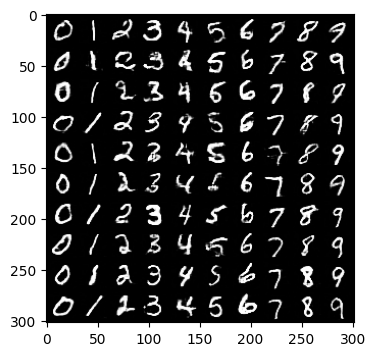

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 6, 4
plt.imshow(mpimg.imread('./gan/sample.png'))

### Submission

You need to submit your code (this notebook), your trained **generator** (named `./gan/gan_best.pth`), your generated images, and your report:

+ **Code**

Remember to run all the cells before submission. Remain your tuned hyperparameters unchanged.

+ **Generator**

In this notebook, we do not include codes to find the best model like the previous ones. You need to visualize generated images, manually select the best one, and save it as `./gan/gan_best.pth`. **Please do not submit any other checkpoints except for `./gan/gan_best.pth`!**

+ **Generated Images**

Please generate 100 images for each class (1000 in total), save it in `./gan/generated/`, and organize them as the following structure:

```
CodingProject3
├── ...
├── gan
│   ├── gan_best.pth
│   ├── generated
│       └── 0
│           ├── 0_00.png
│           ├── ...
│           ├── 0_99.png
│       └── 1
│           ├── 1_00.png
│           ├── ...
│           ├── 1_99.png
│       └── ...
│       └── 9
│           ├── 9_00.png
│           ├── ...
│           ├── 9_99.png
```

Specifially, you should name the $j$-th generated image of class $i$ as `{i}_{j}.png`, and save it into folder `./gan/generated/{i}/`. Check the `make_dataset` method of Generator for details.

+ **Report**

Please include the conditioned generation results (i.e., generated images in a $10\times 10$ array as above), the FID score, the standard deviation for each class, and other relevant statistics in your
report. Note that you only need to write a single report for this coding project.

### Grading

We will evaluate your model by **computing the [FID score](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)**, as what we do for conditioned VAE.

In addition, the standard deviation of your generated images within
each class must **exceed a certain threshold**. Suppose the generated samples for
each class are of size (number of samples, 28, 28) with pixel values range
from 0 to 1, the standard deviation is given by `torch.std(samples, dim=0).mean()`. The thresholds for different digits are listed in the following table:

| Digit | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    |
|-------|------|------|------|------|------|------|------|------|------|------|
| Threshold   | 0.17 | 0.08 | 0.17 | 0.15 | 0.14 | 0.16 | 0.15 | 0.13 | 0.15 | 0.13 |

### Tips

+ Monitoring the generated images in the training process. The quality of the samples helps judge the generator's ability to learn a diverse representation of the input data distribution.

+ See [here](https://developers.google.com/machine-learning/gan/problems) for tricks to prevent mode collapse.

+ Make sure your runs fine with the evaluation file in this notebook.

## Set Up Code

In [2]:
%load_ext autoreload
%autoreload 2

If you use Colab in this coding project, please uncomment the code, fill the `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` and run the following cells to mount your Google drive. Then, the notebook can find the required file (i.e., utils.py). If you run the notebook locally, you can skip the following cells.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import os

# # TODO: Fill in the Google Drive path where you uploaded the assignment
# # Example: If you create a 2022SP folder and put all the files under CP1 folder, then '2022SP/CP1'
# # GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2022SP/CP1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None 
# GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))

In [5]:
# import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

In [6]:
from utils import hello
hello()

/home/zhh/anaconda3/envs/DYY/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Good luck!


Finally, please run the following cell to import some base classes for implementation (no matter whether you use colab).

In [7]:
from collections import deque
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from utils import save_model, load_model, train_set

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

## Generator

Please implement your own generator module, which should be a fully convolutional network with linear projection heads.

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.label_size = label_size = 10
        self.latent_size = latent_size
        
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        self.full_size = self.latent_size + self.label_size
        self.first_layer_size = 2
        self.project = nn.Sequential(
            nn.Linear(self.full_size, 256 * self.first_layer_size * self.first_layer_size),
            nn.ReLU()
        )
        self.c2 = nn.Sequential(
            nn.ConvTranspose2d(256,128,kernel_size=(5,5)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.c3 = nn.Sequential(
            nn.ConvTranspose2d(128,128,kernel_size=(4,4),stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.c4 = nn.Sequential(
            nn.ConvTranspose2d(128,64,kernel_size=(4,4),stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # self.c5 = nn.Sequential(
        #     nn.ConvTranspose2d(64,32,kernel_size=(2,2),stride=2),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU()
        # )
        self.c_final = nn.ConvTranspose2d(64,1,kernel_size=(1,1))
        self.cs = [self.c2,self.c3,self.c4]
        # raise NotImplementedError()
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    def forward(self, z, label):
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        label = torch.scatter(torch.zeros([label.shape[0],10]).to(device),1,label.unsqueeze(1),value=1).to(device)
        x = torch.cat((z,label),dim=1)
        # print(x.shape)
        x = self.project(x)
        # print(x.shape)
        x = x.reshape((-1,256,self.first_layer_size,self.first_layer_size))
        # print(x.shape)
        for ly in self.cs:
            x = ly(x)
            # print(x.shape)
        # print('x.shape',x.shape)
        x = (torch.tanh(self.c_final(x))+1)/2
        # print(x.shape)
        x = x[:,:,1:29,1:29]
        return x
        # raise NotImplementedError()
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    @torch.no_grad()
    def sample_images(self, label, save=True, save_dir='./gan'):
        self.eval()
        n_samples = label.shape[0]
        samples = self(torch.randn(
            n_samples, self.latent_size).to(label.device), label)
        imgs = samples.view(n_samples, 1, 28, 28)
        if save:
            os.makedirs(save_dir, exist_ok=True)
            torchvision.utils.save_image(imgs, os.path.join(
                save_dir, 'sample.png'), nrow=int(np.sqrt(n_samples)))
        return imgs
    
    @torch.no_grad()
    def make_dataset(self, n_samples_per_class=10, save=True, save_dir='./gan/generated/'):
        self.eval()
        device = next(self.parameters()).device
        for i in range(self.label_size):
            label = i * torch.ones(n_samples_per_class, dtype=torch.long, device=device)
            samples = self(torch.randn(
                n_samples_per_class, self.latent_size).to(device), label)
            imgs = samples.view(n_samples_per_class, 1, 28, 28)
            print(f"Standard deviation of number {i}: {torch.std(imgs, dim=0).mean().item()}")
            if save:
                os.makedirs(os.path.join(save_dir, str(i)), exist_ok=True)
                for j in range(n_samples_per_class):
                    torchvision.utils.save_image(imgs[j], os.path.join(save_dir, str(i), "{}_{:>03d}.png".format(i, j)))

## Discriminator

Please implement your own discriminator module, which should also be a fully convolutional network with linear projection heads.

**Hint**: Pay attention to the shape of your output and the shape of label.

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_size = label_size = 10
        
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        self.c2 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=(2,2)),
            # nn.BatchNorm2d(64),
            # nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2)
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(32,2,kernel_size=(2,2),stride=2),
            nn.BatchNorm2d(2),
            # nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2)
        )
        # self.c4 = nn.Sequential(
        #     nn.Conv2d(4,4,kernel_size=(3,3),stride=2),
        #     nn.BatchNorm2d(4),
        #     # nn.Dropout2d(0.2),
        #     nn.LeakyReLU(0.2)
        # )
        self.cs = [self.c2,self.c3]
        self.out_conv_size = 338
        self.mini_batch = 16
        self.B = 100
        self.C = 4
        self.tensor = nn.Linear(self.out_conv_size,self.B * self.C)
        self.linear_size = self.out_conv_size + self.B
        self.project = nn.Sequential(
            nn.Linear(self.linear_size,self.label_size+1),
            # nn.LeakyReLU(0.2),
            # nn.Linear(64,self.label_size+1)
        )
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    def forward(self, img, label):
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        # print(img.shape)
        x = img
        batch_size = img.shape[0]
        x = x.reshape((-1,1,28,28))
        for ly in self.cs:
            x = ly(x)
        x = x.reshape([batch_size,-1])
        o = torch.zeros([batch_size,self.B]).to(device)
        verbose = (label.find('verbose')!=-1)
        # verbose = False
        if label.find('fake') != -1:
            M = self.tensor(x).reshape([batch_size,1,self.B,self.C])
            for down in range(0,batch_size,self.mini_batch):
                M_mini = M[down:down+self.mini_batch]
                delta = M_mini - M_mini.transpose(0,1) # M_mini: i,1,B,C - 1,j,B,C
                delta = torch.permute(delta,[2,0,1,3]) # self.B,mini_batch,mini_batch,self.C
                delta = torch.sum(torch.abs(delta),dim=3)
                c = torch.exp(-delta)
                o[down:down+self.mini_batch] = c.sum(dim=2).T
            if verbose:
                if label.find('dataset') != -1:
                    print('dataset o:',o)
                else:
                    print('generated o:',o)
        else:
            raise NotImplementedError()
        if verbose:
            print('contrast',x[:,:self.B])
        features = x.detach()
        final = self.project(torch.cat((x,o),dim=1))
        return final,features
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

## Training

We have implemented the skeleton of train function. Please complete the missing loss computation part.

In [10]:
def train(n_epochs, generator, discriminator, train_loader, optimizer_g, optimizer_d, device=torch.device('cuda'), save_interval=10):
    generator.to(device)
    discriminator.to(device)
    for epoch in range(n_epochs):
        train_g_loss = train_d_loss = 0
        n_batches = 0
        pbar = tqdm(total=len(train_loader.dataset))
        for i, (x, y) in enumerate(train_loader):
            # compute loss
            n_batches += x.shape[0]
            x = x.to(device)
            y = y.to(device)
            ##############################################################################
            #                  TODO: You need to complete the code here                  #
            ##############################################################################
            # YOUR CODE HERE
            # train discriminator
            VERBOSE_EPOCH = 100
            optimizer_d.zero_grad()
            optimizer_g.zero_grad()
            discriminator.train()
            MINI_BATCH_SIZE = discriminator.mini_batch
            actual_size = ((len(y)//MINI_BATCH_SIZE)*MINI_BATCH_SIZE)
            y = y[:actual_size]
            x = x[:actual_size]
        
            results_real_image,real_features = discriminator(x,"fake_dataset_verbose" if epoch > VERBOSE_EPOCH else 'fake_dataset')
            first = F.cross_entropy(results_real_image,y).mean()
            d_real_acc = ((results_real_image.argmax(dim=1)==y).to(torch.float).mean()).item()
            
            z = torch.randn([y.shape[0],generator.latent_size]).to(device)
            gen_images = generator(z,y)
            output,_ = discriminator(gen_images,"fake_verbose" if epoch > VERBOSE_EPOCH else 'fake')
# print( x * torch.scatter(input=torch.zeros_like(x),index=torch.tensor([[i,y[i]] for i in range(len(y))]),src=torch.ones_like(x),dim=1))
            # with torch.no_grad():
            second = F.cross_entropy(output,(F.one_hot((torch.ones(output.shape[0])*10).to(torch.long),num_classes=11)*0.9).to(device)) #one-side label smoothing
            # -(F.softmax(output,dim=1)[:,10]).mean()
            
            # with torch.no_grad():
            d_fake_acc = ((output.argmax(dim=1)==10).to(torch.float).mean()).item()
            print('d loss:',first.item(),second.item())
            d_loss = first + second
            d_loss.backward()
            optimizer_d.step()

            # train generator
            optimizer_g.zero_grad()
            optimizer_d.zero_grad()
            discriminator.eval()
            z = torch.randn([y.shape[0],generator.latent_size]).to(device)
            gen_images = generator(z,y)
            output,features = discriminator(gen_images,"fake_verbose" if epoch > VERBOSE_EPOCH else 'fake')
            g_loss_first = F.cross_entropy(output,y)
            if real_features is not None:
                g_loss_second = F.mse_loss(features.mean(dim=0),real_features.mean(dim=0))
            else:
                g_loss_second = 0
            print('g loss:',g_loss_first.item(),g_loss_second.item())
            g_loss = g_loss_first  + g_loss_second # feature matching
            g_acc = ((output.argmax(dim=1)==y).to(torch.float).mean()).item()
            g_loss.backward()
            optimizer_g.step()
            if i%2==0:
                pbar.update(x.size(0)*2)
                pbar.set_description('Ep({})GL:({:.6f})DL({:.6f})DrA({:.2f})DfA({:.2f})GA({:.2f})'.format(
                    epoch + 1, train_g_loss / n_batches, train_d_loss / n_batches,d_real_acc*100,d_fake_acc*100,g_acc*100))
            # raise NotImplementedError()
            ##############################################################################
            #                              END OF YOUR CODE                              #
            ##############################################################################

            train_g_loss += g_loss.sum().item()
            train_d_loss += d_loss.sum().item()

            # pbar.update(x.size(0))
            # pbar.set_description('Train Epoch {}, Generator Loss: {:.6f}, Discriminator Loss: {:.6f}'.format(
            #     epoch + 1, train_g_loss / n_batches, train_d_loss / n_batches))
        pbar.close()

        if (epoch + 1) % save_interval == 0:
            os.makedirs(f'./gan/{epoch + 1}', exist_ok=True)
            save_model(f'./gan/{epoch + 1}/gan.pth', generator, optimizer_g,
                       discriminator=discriminator, optimizer_d=optimizer_d)

            # sample and save images
            label = torch.arange(10).repeat(10).to(device)
            generator.sample_images(
                label, save=True, save_dir=f"./gan/{epoch + 1}/")
            # import matplotlib.image as mpimg

            # # Specify the path to the image file
            # image_path = f"./gan/{epoch + 1}/sample.png"

            # # Load the image using mpimg.imread()
            # image = mpimg.imread(image_path)

            # # Display the image using plt.imshow()
            # plt.imshow(image)
            # plt.axis('off')  # Turn off the axis labels
            # plt.show()
            

## Enjoy

Tune your hyperparameters and make your conditional DCGAN work. Good luck!

In [11]:


train_loader = DataLoader(train_set, batch_size=160, pin_memory=True,
                          drop_last=False, shuffle=True, num_workers=2)

g = Generator(100)
d = Discriminator()

optimizer_g = torch.optim.Adam(g.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(d.parameters(), lr=1.5e-4, betas=(0.5, 0.999))

In [12]:
assert(False)

AssertionError: 

Now you can start your training. Please keep in mind that this cell may **NOT** be run when we evaluate your assignment!

In [ ]:
# feel free to change training hyper-parameters!

train(100, g, d, train_loader, optimizer_g, optimizer_d, device=device,save_interval=1)

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 2.642179250717163 2.340597152709961
g loss: 4.40047550201416 0.25028589367866516
d loss: 2.6447880268096924 2.1536052227020264
g loss: 4.269936561584473 0.23130732774734497
d loss: 2.7276241779327393 1.9728336334228516
g loss: 4.440184593200684 0.22287195920944214
d loss: 2.546226739883423 1.853453516960144
g loss: 3.946352481842041 0.23023384809494019
d loss: 2.470198154449463 1.840490698814392
g loss: 3.7195334434509277 0.2298688292503357
d loss: 2.597416639328003 1.9234596490859985
g loss: 3.9384140968322754 0.2206859290599823
d loss: 2.610283374786377 1.9158871173858643
g loss: 3.7720913887023926 0.22688943147659302
d loss: 2.6811282634735107 1.8885586261749268
g loss: 3.935488224029541 0.22095593810081482
d loss: 2.6057515144348145 2.046217679977417
g loss: 3.640355348587036 0.2226121872663498
d loss: 2.5699942111968994 2.1123721599578857
g loss: 3.66748309135437 0.22292734682559967
d loss: 2.5606143474578857 1.8489784002304077
g loss: 3.8736705780029297 0.2268676161766052

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6324572563171387 0.04269091412425041
g loss: 1.7767298221588135 0.2358613759279251
d loss: 0.6864195466041565 0.0831422433257103
g loss: 1.7990652322769165 0.15652360022068024
d loss: 0.6013455390930176 0.013339394703507423
g loss: 2.400120258331299 0.37099123001098633
d loss: 0.6377261877059937 0.006825550924986601
g loss: 4.944890975952148 0.30153772234916687
d loss: 0.6246501207351685 0.00067950040102005
g loss: 10.412132263183594 1.4878089427947998
d loss: 0.5859686732292175 0.0004311963857617229
g loss: 6.448397636413574 1.0721044540405273
d loss: 0.5072018504142761 0.0077819847501814365
g loss: 5.4819841384887695 0.30791816115379333
d loss: 0.5781971216201782 0.08373184502124786
g loss: 4.226372241973877 0.19291597604751587
d loss: 0.6046789288520813 0.020926419645547867
g loss: 3.5968613624572754 0.21023356914520264
d loss: 0.4979829788208008 0.13406911492347717
g loss: 2.315795421600342 0.14557236433029175
d loss: 0.6365224123001099 0.1351475715637207
g loss: 2.939801

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6378098726272583 0.04970062896609306
g loss: 1.707777976989746 0.21684382855892181
d loss: 0.465486615896225 0.07452768087387085
g loss: 1.1483763456344604 0.24093781411647797
d loss: 0.4042584300041199 0.12684109807014465
g loss: 1.0802900791168213 0.22169704735279083
d loss: 0.4193839132785797 0.085804782807827
g loss: 1.3358368873596191 0.18077565729618073
d loss: 0.41294151544570923 0.17771635949611664
g loss: 2.4740214347839355 0.15639139711856842
d loss: 0.5160285830497742 0.15196068584918976
g loss: 3.055966854095459 0.15654198825359344
d loss: 0.6048666834831238 0.026197785511612892
g loss: 1.4413697719573975 0.1854938119649887
d loss: 0.4012375473976135 0.04335596039891243
g loss: 0.8141040802001953 0.21433629095554352
d loss: 0.4489186704158783 0.1319836676120758
g loss: 0.9061456918716431 0.17093321681022644
d loss: 0.4789513051509857 0.18672893941402435
g loss: 1.9848006963729858 0.13038665056228638
d loss: 0.4772130846977234 0.0968286544084549
g loss: 2.379930973

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6342966556549072 0.2909294068813324
g loss: 1.3889896869659424 0.020318085327744484
d loss: 0.47338366508483887 0.46004849672317505
g loss: 1.4433480501174927 0.020563730970025063
d loss: 0.5825716257095337 0.3455274999141693
g loss: 1.6265418529510498 0.018181758001446724
d loss: 0.6203349232673645 0.2610507905483246
g loss: 1.5351238250732422 0.02618667483329773
d loss: 0.572893500328064 0.4405427873134613
g loss: 1.5356428623199463 0.014033453539013863
d loss: 0.8120378255844116 0.3178287148475647
g loss: 1.479992151260376 0.022254323586821556
d loss: 0.6195610761642456 0.3267641067504883
g loss: 1.4311752319335938 0.018592147156596184
d loss: 0.578920841217041 0.32975441217422485
g loss: 1.4552931785583496 0.01981360837817192
d loss: 0.5901780724525452 0.4068126678466797
g loss: 1.723559021949768 0.017404314130544662
d loss: 0.5865607857704163 0.5423462390899658
g loss: 1.872145652770996 0.016964204609394073
d loss: 0.7151637077331543 0.5299456715583801
g loss: 2.22273778

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.5459845662117004 0.5157520174980164
g loss: 1.2597126960754395 0.005569892469793558
d loss: 0.9069828987121582 0.4545123279094696
g loss: 1.3922308683395386 0.008011989295482635
d loss: 0.7323258519172668 0.4747895896434784
g loss: 1.3153542280197144 0.007260280195623636
d loss: 0.6400238275527954 0.6312934756278992
g loss: 1.2799352407455444 0.006390279624611139
d loss: 0.8610016107559204 0.5475080013275146
g loss: 1.1365234851837158 0.010912632569670677
d loss: 0.8385744094848633 0.5173898935317993
g loss: 1.0883867740631104 0.01540128979831934
d loss: 0.7500182390213013 0.4178299903869629
g loss: 0.9429510235786438 0.02479618787765503
d loss: 0.7409390211105347 0.34674373269081116
g loss: 0.9800925254821777 0.02155124582350254
d loss: 0.7505263686180115 0.4773671329021454
g loss: 1.1136301755905151 0.01180100068449974
d loss: 0.6918776631355286 0.5397578477859497
g loss: 1.3558878898620605 0.009378352202475071
d loss: 0.7953519225120544 0.4290545880794525
g loss: 1.4539412

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.9486467242240906 0.3792164623737335
g loss: 0.8999266624450684 0.009000925347208977
d loss: 0.6999627351760864 0.6793490052223206
g loss: 0.8727990388870239 0.00837671011686325
d loss: 0.654975950717926 0.6218529939651489
g loss: 1.1550055742263794 0.00924863200634718
d loss: 0.8397173881530762 0.7787193655967712
g loss: 1.3817204236984253 0.006584049668163061
d loss: 0.8456312417984009 0.6077500581741333
g loss: 1.3468250036239624 0.008614657446742058
d loss: 0.8340213894844055 0.4894947111606598
g loss: 0.9440398216247559 0.006597830913960934
d loss: 0.7788541913032532 0.5658102035522461
g loss: 0.8825345039367676 0.011093794368207455
d loss: 0.6537986993789673 0.5741196274757385
g loss: 1.1415340900421143 0.008868955075740814
d loss: 0.7550156116485596 0.6744313836097717
g loss: 1.1643980741500854 0.006851031444966793
d loss: 0.9021764993667603 0.5484700202941895
g loss: 1.2289488315582275 0.010255665518343449
d loss: 0.8728258013725281 0.5419042706489563
g loss: 1.1923680

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.8510430455207825 0.6145946383476257
g loss: 1.0512959957122803 0.007013299968093634
d loss: 0.956870436668396 0.5551042556762695
g loss: 0.8627218008041382 0.010894378647208214
d loss: 0.6816230416297913 0.7304521799087524
g loss: 0.9939156770706177 0.008913624100387096
d loss: 0.8332683444023132 0.6734705567359924
g loss: 0.9852598309516907 0.003921060357242823
d loss: 0.9072786569595337 0.6682259440422058
g loss: 1.053400993347168 0.005084884352982044
d loss: 0.9284359216690063 0.5704582333564758
g loss: 0.797143816947937 0.009109379723668098
d loss: 0.9271634817123413 0.6023833155632019
g loss: 0.7048348188400269 0.00694956025108695
d loss: 0.6732098460197449 0.6961984038352966
g loss: 0.9188719987869263 0.008140860125422478
d loss: 0.669721782207489 0.7343042492866516
g loss: 1.1830413341522217 0.006194298155605793
d loss: 0.9707915186882019 0.5605007410049438
g loss: 0.9376818537712097 0.005302440375089645
d loss: 0.9147775769233704 0.735504150390625
g loss: 0.8321862220

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.8485366702079773 0.7576887011528015
g loss: 0.8355273008346558 0.00660632224753499
d loss: 0.7163853645324707 0.7019914984703064
g loss: 0.8904552459716797 0.007240648381412029
d loss: 0.8231238126754761 0.7181218266487122
g loss: 0.969537615776062 0.00707542710006237
d loss: 0.9627286791801453 0.6348761916160583
g loss: 0.7168765068054199 0.0052872952073812485
d loss: 0.8924590945243835 0.6462804079055786
g loss: 0.6848306655883789 0.007268389221280813
d loss: 0.7270734310150146 0.6744529604911804
g loss: 0.8322113752365112 0.0059761228039860725
d loss: 0.8144652247428894 0.6718571186065674
g loss: 0.9063431620597839 0.006582888774573803
d loss: 0.8760083317756653 0.512725293636322
g loss: 0.8882073163986206 0.006000426597893238
d loss: 0.8413327932357788 0.5160254836082458
g loss: 0.6651679277420044 0.010892546735703945
d loss: 0.6286041140556335 0.639449417591095
g loss: 0.659284234046936 0.00810780469328165
d loss: 0.7199430465698242 0.6610517501831055
g loss: 0.941652774

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7804077863693237 0.6658644676208496
g loss: 1.2462470531463623 0.008763708174228668
d loss: 0.8189576268196106 0.6091935038566589
g loss: 1.27516770362854 0.007956815883517265
d loss: 0.8112034797668457 0.5550102591514587
g loss: 1.146010398864746 0.007839537225663662
d loss: 0.7999294996261597 0.6289739608764648
g loss: 0.9803430438041687 0.006928142625838518
d loss: 0.8818050622940063 0.7011529803276062
g loss: 0.8779174089431763 0.006025136448442936
d loss: 0.7603846788406372 0.799138069152832
g loss: 0.9074735641479492 0.010833676904439926
d loss: 1.0084242820739746 0.6765976548194885
g loss: 0.7978994846343994 0.007114129606634378
d loss: 0.8831039667129517 0.7953082323074341
g loss: 0.7979086637496948 0.006465113256126642
d loss: 0.8720188140869141 0.578490674495697
g loss: 0.7531678080558777 0.014109569601714611
d loss: 0.8471342325210571 0.6969731450080872
g loss: 0.6940082311630249 0.010330798104405403
d loss: 0.8514696359634399 0.7495313882827759
g loss: 0.841855168

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7134391069412231 0.7139260172843933
g loss: 0.8636927604675293 0.008087516762316227
d loss: 0.7968435287475586 0.6191566586494446
g loss: 0.9458181262016296 0.006179078947752714
d loss: 0.7769467830657959 0.5772162675857544
g loss: 0.7343040704727173 0.005993703380227089
d loss: 0.8116337656974792 0.70217365026474
g loss: 0.8797107934951782 0.005436826962977648
d loss: 0.8875937461853027 0.5789031386375427
g loss: 0.7394770383834839 0.006283375900238752
d loss: 0.7773075699806213 0.6681187152862549
g loss: 0.7761092185974121 0.006217981223016977
d loss: 0.8496659994125366 0.5539917349815369
g loss: 0.8783995509147644 0.006754217203706503
d loss: 0.8041045069694519 0.7196841239929199
g loss: 0.9884263277053833 0.00496482290327549
d loss: 0.7619460821151733 0.7469589114189148
g loss: 1.0413496494293213 0.00717698410153389
d loss: 0.8986136317253113 0.5720769762992859
g loss: 0.8601671457290649 0.0049631488509476185
d loss: 0.797859787940979 0.7429863810539246
g loss: 0.75121617

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7790026664733887 0.794439971446991
g loss: 0.8818566203117371 0.009334993548691273
d loss: 0.9509364366531372 0.6675407290458679
g loss: 0.7689273953437805 0.008618406020104885
d loss: 0.8350790143013 0.8064945340156555
g loss: 0.9324531555175781 0.0087910620495677
d loss: 0.7425955533981323 0.7255033850669861
g loss: 1.2043898105621338 0.006271377205848694
d loss: 0.976423442363739 0.666329562664032
g loss: 0.8705450892448425 0.005255735479295254
d loss: 0.9745413661003113 0.662088930606842
g loss: 0.6812480092048645 0.004557699430733919
d loss: 0.7994154095649719 0.7458446621894836
g loss: 0.7315605878829956 0.006441137753427029
d loss: 0.7620905637741089 0.7510328888893127
g loss: 0.9109169244766235 0.005648632533848286
d loss: 0.8428735733032227 0.6579961180686951
g loss: 1.0996556282043457 0.00577695993706584
d loss: 0.8732448816299438 0.5582506060600281
g loss: 0.8492116928100586 0.00726447394117713
d loss: 0.6745895147323608 0.7702758312225342
g loss: 0.854956924915313

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.9309293031692505 0.633333146572113
g loss: 0.883433997631073 0.009859662503004074
d loss: 0.7643879055976868 0.7637575268745422
g loss: 0.9119884371757507 0.006557656452059746
d loss: 0.8732897639274597 0.7620834112167358
g loss: 0.9604973793029785 0.007366681471467018
d loss: 0.8293819427490234 0.5706458687782288
g loss: 0.9250050783157349 0.00806921161711216
d loss: 0.8537953495979309 0.7408127188682556
g loss: 1.0030219554901123 0.008364051580429077
d loss: 0.8200499415397644 0.6254907846450806
g loss: 0.825031578540802 0.00814732350409031
d loss: 0.8175321817398071 0.7407237887382507
g loss: 0.9594739079475403 0.0077014584094285965
d loss: 0.7936760187149048 0.7138983607292175
g loss: 1.069299578666687 0.008496931754052639
d loss: 0.764668345451355 0.6505654454231262
g loss: 1.1923482418060303 0.007796047255396843
d loss: 0.9418913125991821 0.597625732421875
g loss: 0.8666434288024902 0.007418481633067131
d loss: 0.7911831736564636 0.7423455119132996
g loss: 0.70563954114

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.8573578000068665 0.6290083527565002
g loss: 0.8047889471054077 0.005577003117650747
d loss: 0.6416013240814209 0.7561411261558533
g loss: 0.9981788396835327 0.007369297090917826
d loss: 0.879918098449707 0.7093083262443542
g loss: 1.1610310077667236 0.008073234930634499
d loss: 0.7990714907646179 0.6577770113945007
g loss: 0.9761794805526733 0.004679893609136343
d loss: 0.9299532771110535 0.615695595741272
g loss: 0.6728979349136353 0.006370499264448881
d loss: 0.6284390687942505 0.8559415936470032
g loss: 0.7008320093154907 0.005792827345430851
d loss: 0.7384999990463257 0.7495741844177246
g loss: 0.9365173578262329 0.007688549347221851
d loss: 0.8288719058036804 0.648411750793457
g loss: 1.0416767597198486 0.00785263441503048
d loss: 0.985922634601593 0.5966248512268066
g loss: 0.6969494819641113 0.007045884151011705
d loss: 0.8998812437057495 0.6171457767486572
g loss: 0.5884963870048523 0.014652865938842297
d loss: 0.7906603813171387 0.7486180663108826
g loss: 0.616023480

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7627086043357849 0.623036801815033
g loss: 0.7936711311340332 0.005672309082001448
d loss: 0.7176493406295776 0.6327843070030212
g loss: 0.816208004951477 0.006738307420164347
d loss: 0.7584927678108215 0.6218342185020447
g loss: 0.882341742515564 0.004806318320333958
d loss: 0.9436722993850708 0.5771574974060059
g loss: 0.7787682414054871 0.004374158568680286
d loss: 0.7475531101226807 0.5904141664505005
g loss: 0.7219338417053223 0.007930638268589973
d loss: 0.7521315217018127 0.6858913898468018
g loss: 0.7951022386550903 0.011889773420989513
d loss: 0.7252638339996338 0.6417834162712097
g loss: 0.8615895509719849 0.008359878323972225
d loss: 0.7503455877304077 0.571151077747345
g loss: 0.7430451512336731 0.004621958825737238
d loss: 0.9002227783203125 0.5663937926292419
g loss: 0.6074993014335632 0.00893286895006895
d loss: 0.7181724905967712 0.6241093873977661
g loss: 0.700054943561554 0.01078123040497303
d loss: 0.750865638256073 0.5991536974906921
g loss: 0.776202619075

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7493916749954224 0.7717609405517578
g loss: 0.9593304395675659 0.005248658824712038
d loss: 0.7120359539985657 0.7861086130142212
g loss: 1.1883766651153564 0.010839096270501614
d loss: 0.8697918057441711 0.5500133037567139
g loss: 1.0340667963027954 0.0067678047344088554
d loss: 0.9493303298950195 0.5294699668884277
g loss: 0.7069622874259949 0.0054743727669119835
d loss: 0.742445170879364 0.6960361003875732
g loss: 0.7533910274505615 0.005885845050215721
d loss: 0.748797595500946 0.7169042825698853
g loss: 0.7469910383224487 0.006633346900343895
d loss: 0.7768620252609253 0.7236711382865906
g loss: 0.8133543729782104 0.009007664397358894
d loss: 0.7961080074310303 0.689953625202179
g loss: 0.899082362651825 0.006739035248756409
d loss: 0.7580922842025757 0.6338549852371216
g loss: 0.8702534437179565 0.006282361224293709
d loss: 0.7257480025291443 0.6834878325462341
g loss: 0.9364062547683716 0.007055279798805714
d loss: 0.9003418684005737 0.6071985363960266
g loss: 0.772732

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7489951848983765 0.7226471900939941
g loss: 0.9489325284957886 0.006072827614843845
d loss: 0.8061659932136536 0.6024113893508911
g loss: 0.7989089488983154 0.006672405172139406
d loss: 0.7867719531059265 0.6624501347541809
g loss: 0.7638384103775024 0.007726340554654598
d loss: 0.6983360052108765 0.6693153977394104
g loss: 0.8403037190437317 0.007952592335641384
d loss: 0.7242871522903442 0.6102020144462585
g loss: 0.9948168992996216 0.0074720135889947414
d loss: 0.895077109336853 0.5981317162513733
g loss: 0.9468290209770203 0.008929499424993992
d loss: 0.8928764462471008 0.6230770349502563
g loss: 0.6571479439735413 0.006791232153773308
d loss: 0.8490740060806274 0.7626637816429138
g loss: 0.7223117351531982 0.01191377080976963
d loss: 0.6708652377128601 0.7777868509292603
g loss: 0.8460029363632202 0.004312156233936548
d loss: 0.7960404753684998 0.6313217282295227
g loss: 0.7716201543807983 0.005199762061238289
d loss: 0.8533919453620911 0.6811062693595886
g loss: 0.75152

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7654399275779724 0.5706124305725098
g loss: 0.7484019994735718 0.005401020869612694
d loss: 0.6906181573867798 0.6748122572898865
g loss: 0.8893221020698547 0.0050127822905778885
d loss: 0.7552584409713745 0.6449567675590515
g loss: 0.850142776966095 0.005924869794398546
d loss: 0.8175324201583862 0.5893422961235046
g loss: 0.8257856369018555 0.005104076117277145
d loss: 0.781557023525238 0.656505286693573
g loss: 0.8478769063949585 0.01043986901640892
d loss: 0.7932578325271606 0.6846337914466858
g loss: 0.8865617513656616 0.006059846840798855
d loss: 0.8323443531990051 0.7031619548797607
g loss: 0.8920402526855469 0.006285934243351221
d loss: 0.8231678009033203 0.7193949818611145
g loss: 0.9298958778381348 0.005327870137989521
d loss: 0.844700038433075 0.7026048302650452
g loss: 0.8923041224479675 0.004849093034863472
d loss: 0.8220788240432739 0.616095244884491
g loss: 0.7306403517723083 0.006602080538868904
d loss: 0.7433041334152222 0.6325876116752625
g loss: 0.730958402

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.8845445513725281 0.6636672019958496
g loss: 0.8925129175186157 0.005329489707946777
d loss: 0.8057616949081421 0.6361484527587891
g loss: 0.9336690902709961 0.0055542923510074615
d loss: 0.7455772757530212 0.6585038900375366
g loss: 0.9926160573959351 0.006329142954200506
d loss: 0.8617294430732727 0.5881686210632324
g loss: 0.7110565900802612 0.00874532200396061
d loss: 0.7025763988494873 0.7715826034545898
g loss: 0.808210015296936 0.004395941738039255
d loss: 0.7158440947532654 0.6192525029182434
g loss: 0.8122922778129578 0.0048038591630756855
d loss: 0.7548225522041321 0.686123788356781
g loss: 0.881201446056366 0.006774426903575659
d loss: 0.8429678082466125 0.5537182688713074
g loss: 0.7962924242019653 0.005395174957811832
d loss: 0.7815168499946594 0.7927757501602173
g loss: 0.9706646203994751 0.007889404892921448
d loss: 0.91346275806427 0.5040721893310547
g loss: 0.6948504447937012 0.0066369096748530865
d loss: 0.7162674069404602 0.64695805311203
g loss: 0.674888789

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.8222905993461609 0.7744634747505188
g loss: 0.8529847264289856 0.007670557592064142
d loss: 0.7172216176986694 0.6363583207130432
g loss: 0.9609919786453247 0.008081598207354546
d loss: 0.8870459794998169 0.6589247584342957
g loss: 0.8061915636062622 0.006491239182651043
d loss: 0.7559762597084045 0.6038194894790649
g loss: 0.9420896768569946 0.009236249141395092
d loss: 0.7237015962600708 0.7062150835990906
g loss: 0.9633882641792297 0.010264105163514614
d loss: 0.8849932551383972 0.5635849833488464
g loss: 0.674372136592865 0.008415368385612965
d loss: 0.7364824414253235 0.7795456051826477
g loss: 0.7843149304389954 0.006719620432704687
d loss: 0.7401950359344482 0.7316486239433289
g loss: 1.0886614322662354 0.008955501951277256
d loss: 0.806383490562439 0.6430036425590515
g loss: 0.9968922734260559 0.010494242422282696
d loss: 0.7836646437644958 0.5965124368667603
g loss: 1.0370690822601318 0.006097371224313974
d loss: 0.7497131824493408 0.6961022615432739
g loss: 0.934151

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.8916870951652527 0.5490841865539551
g loss: 0.7169371843338013 0.007436458952724934
d loss: 0.8261111974716187 0.7751035094261169
g loss: 0.7053641080856323 0.011812413111329079
d loss: 0.7470867037773132 0.7728375196456909
g loss: 0.9995934367179871 0.012119818478822708
d loss: 0.8394812345504761 0.7099148035049438
g loss: 1.071928858757019 0.008816058747470379
d loss: 0.8343100547790527 0.6705805063247681
g loss: 0.8348020315170288 0.008799979463219643
d loss: 0.9517083168029785 0.6106556057929993
g loss: 0.6622444987297058 0.007556416094303131
d loss: 0.6945053339004517 0.6509730219841003
g loss: 0.6093468070030212 0.0132582513615489
d loss: 0.5882116556167603 0.8094982504844666
g loss: 1.0196373462677002 0.009687227196991444
d loss: 0.98515784740448 0.5321976542472839
g loss: 0.8250117301940918 0.011596448719501495
d loss: 0.7812449336051941 0.628247082233429
g loss: 0.796585202217102 0.008351228199899197
d loss: 0.8506237864494324 0.7139296531677246
g loss: 0.73845350742

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7941755056381226 0.6593852043151855
g loss: 1.022179365158081 0.006116322707384825
d loss: 0.8052260279655457 0.5809562802314758
g loss: 0.8190847635269165 0.005325923208147287
d loss: 0.7523069977760315 0.584354043006897
g loss: 0.5223151445388794 0.010561968199908733
d loss: 0.5861038565635681 0.7917096018791199
g loss: 0.8185531497001648 0.006967651192098856
d loss: 0.776598334312439 0.6336385607719421
g loss: 1.1134542226791382 0.005259623285382986
d loss: 0.9564288854598999 0.4609350860118866
g loss: 0.6436487436294556 0.010936925187706947
d loss: 0.7441038489341736 0.6392820477485657
g loss: 0.6583365797996521 0.012763336300849915
d loss: 0.6374350786209106 0.7032608389854431
g loss: 0.9240214228630066 0.00582228135317564
d loss: 0.8010711669921875 0.6094502806663513
g loss: 1.0907872915267944 0.005542534403502941
d loss: 0.6924834847450256 0.574301540851593
g loss: 0.8073892593383789 0.00637722946703434
d loss: 0.7798525094985962 0.6130475997924805
g loss: 0.8416410684

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7335658669471741 0.7014691233634949
g loss: 1.08793306350708 0.009630857966840267
d loss: 0.8675233721733093 0.6447062492370605
g loss: 1.1007874011993408 0.009425818920135498
d loss: 0.8932162523269653 0.6137063503265381
g loss: 0.724844217300415 0.006089635193347931
d loss: 0.6548882126808167 0.750228226184845
g loss: 0.7907062768936157 0.006097256205976009
d loss: 0.5578449964523315 0.597137451171875
g loss: 1.1365787982940674 0.007077539339661598
d loss: 0.8187583684921265 0.6018062829971313
g loss: 0.8962734937667847 0.008826489560306072
d loss: 0.7355944514274597 0.5696749091148376
g loss: 0.7336639165878296 0.009809101931750774
d loss: 0.7526034116744995 0.6299764513969421
g loss: 0.6265200972557068 0.01234490517526865
d loss: 0.6527099609375 0.6855630874633789
g loss: 0.780507504940033 0.011475035920739174
d loss: 0.7300194501876831 0.6775908470153809
g loss: 0.8051019906997681 0.00971573032438755
d loss: 0.7874060869216919 0.6132658123970032
g loss: 0.806260466575622

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7658430337905884 0.6743950843811035
g loss: 0.8303192853927612 0.006786375306546688
d loss: 0.7957038879394531 0.6142763495445251
g loss: 0.8912813067436218 0.004366247449070215
d loss: 0.7651811838150024 0.61212557554245
g loss: 0.9248155355453491 0.005933044943958521
d loss: 0.7533060312271118 0.5912402868270874
g loss: 0.7697139978408813 0.004647556692361832
d loss: 0.7318428754806519 0.6856563687324524
g loss: 0.7983955144882202 0.007283989805728197
d loss: 0.7042590379714966 0.6512728929519653
g loss: 1.1324169635772705 0.007544748950749636
d loss: 0.7882155179977417 0.5219016075134277
g loss: 1.0351344347000122 0.004153883550316095
d loss: 0.6912321448326111 0.6396156549453735
g loss: 0.9963817596435547 0.006102914921939373
d loss: 0.8105538487434387 0.5009345412254333
g loss: 0.9244286417961121 0.007258135825395584
d loss: 0.7295837998390198 0.6812673807144165
g loss: 0.6977357268333435 0.008105790242552757
d loss: 0.648384690284729 0.7499003410339355
g loss: 1.0354487

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7719982862472534 0.5977171063423157
g loss: 0.8769563436508179 0.012128353118896484
d loss: 0.6428149938583374 0.6931287050247192
g loss: 0.9333391189575195 0.012864520773291588
d loss: 0.7374774813652039 0.7149291634559631
g loss: 1.0847822427749634 0.008600848726928234
d loss: 0.789146900177002 0.5512961745262146
g loss: 0.9218651056289673 0.009307153522968292
d loss: 0.7542575001716614 0.5669760704040527
g loss: 0.8209125399589539 0.007389390375465155
d loss: 0.7189077734947205 0.5562093257904053
g loss: 0.8035348653793335 0.0072768679820001125
d loss: 0.6739415526390076 0.6842812895774841
g loss: 1.0038790702819824 0.011715252883732319
d loss: 0.7239282727241516 0.5801076292991638
g loss: 0.9769467115402222 0.008189563639461994
d loss: 0.7441177368164062 0.6280941963195801
g loss: 0.8185202479362488 0.010582839138805866
d loss: 0.826992392539978 0.6235127449035645
g loss: 0.6235207915306091 0.00966296810656786
d loss: 0.703642725944519 0.7119680643081665
g loss: 0.6537209

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6354557275772095 0.6606610417366028
g loss: 0.8506722450256348 0.006639998406171799
d loss: 0.7844855189323425 0.655346691608429
g loss: 0.7427012324333191 0.006844968535006046
d loss: 0.6474692821502686 0.6471495628356934
g loss: 0.9306284785270691 0.008756275288760662
d loss: 0.8854495286941528 0.6360929608345032
g loss: 0.757023811340332 0.008762452751398087
d loss: 0.7003926038742065 0.7172852754592896
g loss: 0.892012894153595 0.009832332842051983
d loss: 0.7782944440841675 0.608736515045166
g loss: 0.8556159138679504 0.010155064053833485
d loss: 0.7035934925079346 0.6048356294631958
g loss: 0.8369110226631165 0.00809035636484623
d loss: 0.7554775476455688 0.5803686380386353
g loss: 0.7960960268974304 0.00893100444227457
d loss: 0.7430155277252197 0.614769697189331
g loss: 0.7620810270309448 0.009232353419065475
d loss: 0.639194130897522 0.6255353093147278
g loss: 1.050549864768982 0.008357725106179714
d loss: 0.7769675254821777 0.5648981332778931
g loss: 0.9134499430656

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.796260416507721 0.6849622130393982
g loss: 0.6295872330665588 0.007252214942127466
d loss: 0.7688418626785278 0.6925523281097412
g loss: 0.7236229181289673 0.007533500902354717
d loss: 0.6700000762939453 0.728160560131073
g loss: 1.0362918376922607 0.004055591765791178
d loss: 0.912956714630127 0.5443611741065979
g loss: 0.809281051158905 0.006969166453927755
d loss: 0.777187705039978 0.6556896567344666
g loss: 0.8558063507080078 0.007434247527271509
d loss: 0.6730123162269592 0.6444515585899353
g loss: 0.8928933143615723 0.00539280055090785
d loss: 0.8060227632522583 0.5874795913696289
g loss: 0.8706185221672058 0.005018109921365976
d loss: 0.7507836222648621 0.68184494972229
g loss: 0.8818603754043579 0.00671504158526659
d loss: 0.8039757609367371 0.7134830355644226
g loss: 0.932335376739502 0.004872127436101437
d loss: 0.7625476121902466 0.6770864725112915
g loss: 1.0089255571365356 0.007919874973595142
d loss: 0.7829352617263794 0.725041389465332
g loss: 1.063812732696533

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7790910005569458 0.5460324287414551
g loss: 0.927364706993103 0.006174871232360601
d loss: 0.675137460231781 0.5995311141014099
g loss: 0.9067238569259644 0.008330813609063625
d loss: 0.7140421271324158 0.5198661684989929
g loss: 0.9034129977226257 0.008324280381202698
d loss: 0.7461059093475342 0.5815691947937012
g loss: 0.9727717638015747 0.006720826495438814
d loss: 0.7225886583328247 0.7285864949226379
g loss: 0.91258305311203 0.005435858853161335
d loss: 0.7881088256835938 0.5385739207267761
g loss: 0.7056658864021301 0.006594286300241947
d loss: 0.6073996424674988 0.7369086146354675
g loss: 0.929063618183136 0.00820503756403923
d loss: 0.7900857925415039 0.70474773645401
g loss: 1.2663010358810425 0.009997078217566013
d loss: 0.9247640371322632 0.5554737448692322
g loss: 0.8552425503730774 0.005604978650808334
d loss: 0.6937987804412842 0.6211106181144714
g loss: 0.7671905755996704 0.005685559008270502
d loss: 0.7797391414642334 0.7066897749900818
g loss: 0.885304927825

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7003664374351501 0.7074266672134399
g loss: 1.0455543994903564 0.00985538586974144
d loss: 0.7099111080169678 0.5677400231361389
g loss: 1.1465041637420654 0.010061286389827728
d loss: 0.8205119371414185 0.6154156923294067
g loss: 0.7802327871322632 0.005873159039765596
d loss: 0.7370011210441589 0.6865019798278809
g loss: 0.83087158203125 0.006510662846267223
d loss: 0.6847720742225647 0.800273597240448
g loss: 1.2834070920944214 0.0066087860614061356
d loss: 0.8722864389419556 0.5518296360969543
g loss: 0.9766194224357605 0.008461365476250648
d loss: 0.7736879587173462 0.6425094604492188
g loss: 0.9380423426628113 0.008863810449838638
d loss: 0.7070172429084778 0.7962241768836975
g loss: 1.1022987365722656 0.011817505583167076
d loss: 0.8066547513008118 0.6388325095176697
g loss: 1.0377819538116455 0.0069353156723082066
d loss: 0.8155039548873901 0.5333467125892639
g loss: 0.8433058857917786 0.005811430513858795
d loss: 0.768815815448761 0.6308572888374329
g loss: 0.8097617

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6614333987236023 0.5373358130455017
g loss: 0.648556113243103 0.01062015164643526
d loss: 0.5898829698562622 0.7934789061546326
g loss: 1.099847435951233 0.005468234419822693
d loss: 0.831326961517334 0.6226824522018433
g loss: 1.0503675937652588 0.005070350132882595
d loss: 0.8306261897087097 0.5920017957687378
g loss: 0.9193108677864075 0.006054118741303682
d loss: 0.6647343635559082 0.5806921124458313
g loss: 0.7498315572738647 0.0072629740461707115
d loss: 0.7221748232841492 0.749607503414154
g loss: 0.7468177080154419 0.005626519676297903
d loss: 0.6163817644119263 0.7148017287254333
g loss: 1.009192705154419 0.007492769975215197
d loss: 0.855135440826416 0.5691167116165161
g loss: 0.8111104965209961 0.008557257242500782
d loss: 0.7507284879684448 0.5863630175590515
g loss: 0.6907688975334167 0.013719623908400536
d loss: 0.6290480494499207 0.7266730070114136
g loss: 0.7660267949104309 0.006047969684004784
d loss: 0.6967953443527222 0.5563214421272278
g loss: 0.8275230526

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.926916241645813 0.5967302918434143
g loss: 0.6784759759902954 0.008328116498887539
d loss: 0.5960690975189209 0.8141477704048157
g loss: 0.713298499584198 0.00844823382794857
d loss: 0.6592636108398438 0.6762939691543579
g loss: 1.073498249053955 0.009899470023810863
d loss: 0.7090035676956177 0.6327459216117859
g loss: 1.2650659084320068 0.012809911742806435
d loss: 0.6923580169677734 0.5336386561393738
g loss: 1.0551748275756836 0.007100580260157585
d loss: 0.7420923113822937 0.6232388615608215
g loss: 0.9685603976249695 0.0054932101629674435
d loss: 0.7571395635604858 0.6940755248069763
g loss: 0.9638705253601074 0.006892431527376175
d loss: 0.7030900716781616 0.5685679316520691
g loss: 0.899260401725769 0.004446539096534252
d loss: 0.644460141658783 0.59238600730896
g loss: 0.8415884971618652 0.006434128154069185
d loss: 0.743219256401062 0.6531103253364563
g loss: 0.8871256709098816 0.006383084692060947
d loss: 0.852608859539032 0.5319725275039673
g loss: 0.5863370299339

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7022556066513062 0.5907288789749146
g loss: 0.8428638577461243 0.008516921661794186
d loss: 0.706244707107544 0.6741915941238403
g loss: 1.1801328659057617 0.007052349857985973
d loss: 0.7146115899085999 0.49716684222221375
g loss: 1.1833288669586182 0.006663977168500423
d loss: 0.7920452356338501 0.6055554747581482
g loss: 0.9323785901069641 0.004878925159573555
d loss: 0.6200052499771118 0.6958818435668945
g loss: 1.0392777919769287 0.007653140462934971
d loss: 0.8215556144714355 0.5911893844604492
g loss: 0.9359040260314941 0.00663670664653182
d loss: 0.6937744617462158 0.6591503024101257
g loss: 1.0905112028121948 0.006761336699128151
d loss: 0.760150671005249 0.5843732953071594
g loss: 0.7784945368766785 0.005962069146335125
d loss: 0.7734987735748291 0.6443764567375183
g loss: 0.7611765265464783 0.005877428688108921
d loss: 0.6738200187683105 0.7511823773384094
g loss: 0.975415825843811 0.007209585979580879
d loss: 0.72278892993927 0.6598071455955505
g loss: 0.914493203

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6734810471534729 0.676380455493927
g loss: 1.0182888507843018 0.008866164833307266
d loss: 0.8380468487739563 0.6084916591644287
g loss: 0.9130240678787231 0.007088569458574057
d loss: 0.6851902008056641 0.6333330273628235
g loss: 0.9941743612289429 0.005942653864622116
d loss: 0.7927356958389282 0.49553653597831726
g loss: 0.6587759256362915 0.012179267592728138
d loss: 0.7369474172592163 0.7422662973403931
g loss: 0.6655572056770325 0.009929320774972439
d loss: 0.49865326285362244 0.7695862054824829
g loss: 1.1849851608276367 0.010828573256731033
d loss: 0.7748509049415588 0.5918289422988892
g loss: 1.0546189546585083 0.0072836666367948055
d loss: 0.8728078603744507 0.5220296382904053
g loss: 0.766181468963623 0.009424271993339062
d loss: 0.5971654653549194 0.7115669846534729
g loss: 0.7684026956558228 0.007718491367995739
d loss: 0.7097548842430115 0.6494058966636658
g loss: 0.8259663581848145 0.00711677223443985
d loss: 0.6881977915763855 0.6895865797996521
g loss: 0.8379

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6186048984527588 0.7488816380500793
g loss: 1.4968422651290894 0.009885206818580627
d loss: 0.9659411311149597 0.45610132813453674
g loss: 0.9882107973098755 0.008460434153676033
d loss: 0.7847805619239807 0.5583524703979492
g loss: 0.7515133619308472 0.012163856066763401
d loss: 0.5912479758262634 0.8226198554039001
g loss: 1.0176552534103394 0.008796454407274723
d loss: 0.6134192943572998 0.6099528670310974
g loss: 1.187371015548706 0.010327172465622425
d loss: 0.8386823534965515 0.504723072052002
g loss: 0.9164878726005554 0.006476107519119978
d loss: 0.7155036330223083 0.6434566974639893
g loss: 0.9728263020515442 0.00801812019199133
d loss: 0.7164175510406494 0.6758272051811218
g loss: 1.1173923015594482 0.007862814702093601
d loss: 0.7132785320281982 0.6462598443031311
g loss: 1.1112697124481201 0.009091205894947052
d loss: 0.7706443071365356 0.6982526183128357
g loss: 1.0687189102172852 0.008829732425510883
d loss: 0.7237629294395447 0.629401683807373
g loss: 1.0603072

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.5551125407218933 0.857450008392334
g loss: 0.7487486600875854 0.08380751311779022
d loss: 0.5828456282615662 1.0037065744400024
g loss: 1.6311779022216797 0.09228961169719696
d loss: 1.039175033569336 0.3603081703186035
g loss: 0.8175598978996277 0.10075540095567703
d loss: 0.6932984590530396 0.5423302054405212
g loss: 0.6420304775238037 0.11646871268749237
d loss: 0.6097318530082703 0.7124462723731995
g loss: 0.8098368644714355 0.10026752203702927
d loss: 0.6215490698814392 0.5643488168716431
g loss: 1.1918748617172241 0.0961189717054367
d loss: 0.8098291158676147 0.47164756059646606
g loss: 0.8093885183334351 0.10703095048666
d loss: 0.7348406314849854 0.4970646798610687
g loss: 0.7889876365661621 0.10062279552221298
d loss: 0.5718122720718384 0.5996207594871521
g loss: 1.1561890840530396 0.0972597673535347
d loss: 0.633029580116272 0.5649042129516602
g loss: 1.7572972774505615 0.10969617962837219
d loss: 0.7498523592948914 0.3764835298061371
g loss: 1.1783078908920288 0.09

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6853463053703308 0.4594077169895172
g loss: 0.6965442299842834 0.036180295050144196
d loss: 0.551702082157135 0.7192879915237427
g loss: 1.2638366222381592 0.02459261193871498
d loss: 0.5905596613883972 0.44208794832229614
g loss: 1.4126311540603638 0.022738229483366013
d loss: 0.7695095539093018 0.34883737564086914
g loss: 0.6291465759277344 0.03911351040005684
d loss: 0.3249122202396393 0.7034849524497986
g loss: 1.1451857089996338 0.023671258240938187
d loss: 0.6293493509292603 0.3997260332107544
g loss: 1.4272115230560303 0.023785151541233063
d loss: 0.6147758960723877 0.36284953355789185
g loss: 1.1286942958831787 0.029517676681280136
d loss: 0.6712002754211426 0.3893941044807434
g loss: 0.715399444103241 0.041086308658123016
d loss: 0.42947521805763245 0.6133578419685364
g loss: 0.9240632057189941 0.032533153891563416
d loss: 0.6830569505691528 0.40350601077079773
g loss: 1.099515438079834 0.031156085431575775
d loss: 0.635635256767273 0.46581584215164185
g loss: 1.1785

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.5137774348258972 0.9038139581680298
g loss: 0.9238540530204773 0.009216182865202427
d loss: 0.527703046798706 0.7952289581298828
g loss: 1.8867801427841187 0.011483975686132908
d loss: 1.1191794872283936 0.3302482068538666
g loss: 0.9062622785568237 0.008907199837267399
d loss: 0.7454878091812134 0.5045326948165894
g loss: 0.5076984167098999 0.016093168407678604
d loss: 0.4192729890346527 0.7083041667938232
g loss: 0.9013795852661133 0.009256458841264248
d loss: 0.5701903700828552 0.6613505482673645
g loss: 1.6778995990753174 0.009781685657799244
d loss: 1.061143159866333 0.26422521471977234
g loss: 0.6325355768203735 0.013602516613900661
d loss: 0.5700227618217468 0.6811371445655823
g loss: 0.579056441783905 0.008857996203005314
d loss: 0.52708899974823 0.6663581132888794
g loss: 0.7711135149002075 0.009619022719562054
d loss: 0.8623042106628418 0.5100679993629456
g loss: 0.8578122854232788 0.006781976670026779
d loss: 0.8062607049942017 0.6142405867576599
g loss: 0.79885327

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7877103090286255 0.5290111899375916
g loss: 0.8214608430862427 0.015166613273322582
d loss: 0.928682804107666 0.6207002997398376
g loss: 0.5442948937416077 0.010480359196662903
d loss: 0.5389578342437744 0.9594603776931763
g loss: 1.0447492599487305 0.014327499084174633
d loss: 0.9474498629570007 0.540838897228241
g loss: 0.6369940042495728 0.005531538277864456
d loss: 0.6254516839981079 0.8129434585571289
g loss: 0.8582457304000854 0.0058815558440983295
d loss: 0.718675971031189 0.661858081817627
g loss: 0.9318897128105164 0.009875546209514141
d loss: 0.6860249042510986 0.65310138463974
g loss: 1.0756752490997314 0.005653283558785915
d loss: 0.7640018463134766 0.5219514966011047
g loss: 1.042626142501831 0.0057194107212126255
d loss: 0.7425135970115662 0.5375458002090454
g loss: 0.7744492888450623 0.00976426899433136
d loss: 0.6541482210159302 0.7087849974632263
g loss: 0.8619924783706665 0.008632734417915344
d loss: 0.6040655374526978 0.6824437379837036
g loss: 1.1510425806

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.9223276376724243 0.5135478973388672
g loss: 0.7148478627204895 0.01119754184037447
d loss: 0.5974289774894714 0.7438563704490662
g loss: 0.7207086682319641 0.008263778872787952
d loss: 0.6850841045379639 0.795449435710907
g loss: 1.1775856018066406 0.007790945004671812
d loss: 0.7541301250457764 0.6359739303588867
g loss: 1.0954300165176392 0.007008178625255823
d loss: 0.8123413920402527 0.5418416261672974
g loss: 0.8164265751838684 0.00650435034185648
d loss: 0.7531015872955322 0.5818474888801575
g loss: 0.6771217584609985 0.007902695797383785
d loss: 0.6519128084182739 0.5943232178688049
g loss: 0.7824305295944214 0.007236112374812365
d loss: 0.5983958840370178 0.6557132601737976
g loss: 0.8491992950439453 0.008277022279798985
d loss: 0.8918445706367493 0.6170057654380798
g loss: 0.6613211631774902 0.0065078940242528915
d loss: 0.604723334312439 0.6974846720695496
g loss: 0.7396609783172607 0.008926057256758213
d loss: 0.7505218982696533 0.5983842015266418
g loss: 0.6592546

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.8146109580993652 0.5279453992843628
g loss: 0.9129742383956909 0.009415950626134872
d loss: 0.6887496709823608 0.616491436958313
g loss: 0.8301749229431152 0.009646086022257805
d loss: 0.5408260822296143 0.6322433352470398
g loss: 1.1688792705535889 0.004661536775529385
d loss: 0.8384849429130554 0.5696744322776794
g loss: 0.9740985631942749 0.006440461613237858
d loss: 0.6470597982406616 0.684083878993988
g loss: 1.092666506767273 0.007847240194678307
d loss: 0.6573216319084167 0.6654822826385498
g loss: 1.1018744707107544 0.007272796705365181
d loss: 0.8443285226821899 0.481423944234848
g loss: 0.78681480884552 0.007845302112400532
d loss: 0.5902202129364014 0.643535852432251
g loss: 0.7456803321838379 0.005654186476022005
d loss: 0.6145507097244263 0.5813035368919373
g loss: 0.8785697221755981 0.009615725837647915
d loss: 0.5768283009529114 0.5612193942070007
g loss: 1.025547742843628 0.006422571372240782
d loss: 0.791563868522644 0.5561285614967346
g loss: 0.8702381849288

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6478272676467896 0.5089501738548279
g loss: 1.091366171836853 0.007924232631921768
d loss: 0.7770234942436218 0.5548474192619324
g loss: 0.9182756543159485 0.0038840468041598797
d loss: 0.7133051156997681 0.591298520565033
g loss: 0.7978172302246094 0.004775926470756531
d loss: 0.7005757689476013 0.6224930882453918
g loss: 0.998247504234314 0.004533127415925264
d loss: 0.7932870984077454 0.5780643820762634
g loss: 0.9994317293167114 0.004716196563094854
d loss: 0.7187970876693726 0.7202796936035156
g loss: 0.9362753629684448 0.008422454819083214
d loss: 0.7740694880485535 0.5864162445068359
g loss: 0.8960862159729004 0.00745523814111948
d loss: 0.9600423574447632 0.6222217082977295
g loss: 0.6126217246055603 0.004799932707101107
d loss: 0.5985949635505676 0.6915526390075684
g loss: 0.668376624584198 0.005971170961856842
d loss: 0.6158983111381531 0.6353302001953125
g loss: 1.0222647190093994 0.011457571759819984
d loss: 0.7961409091949463 0.5457825064659119
g loss: 0.92356699

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7008056044578552 0.5431327223777771
g loss: 1.1014949083328247 0.004967397078871727
d loss: 0.7626109719276428 0.5658925175666809
g loss: 0.8502131700515747 0.007212504744529724
d loss: 0.5876844525337219 0.6510302424430847
g loss: 0.936628520488739 0.004263928160071373
d loss: 0.7393670678138733 0.5340701937675476
g loss: 0.8209173083305359 0.005734121892601252
d loss: 0.6961991190910339 0.6284972429275513
g loss: 0.6721225380897522 0.008805740624666214
d loss: 0.6250463128089905 0.73689204454422
g loss: 1.0019431114196777 0.005156500730663538
d loss: 0.5898393392562866 0.6112543344497681
g loss: 1.1988542079925537 0.006012809928506613
d loss: 0.725396990776062 0.5560509562492371
g loss: 1.2925260066986084 0.005390171427279711
d loss: 0.6764059066772461 0.6002817153930664
g loss: 1.1040174961090088 0.006800957955420017
d loss: 0.7911094427108765 0.6340202689170837
g loss: 0.9982574582099915 0.006967207416892052
d loss: 0.7541887164115906 0.577813446521759
g loss: 0.777970612

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.5704788565635681 0.5764291286468506
g loss: 0.8616747856140137 0.0045233676210045815
d loss: 0.7187864780426025 0.8086673021316528
g loss: 0.9313968420028687 0.006301003973931074
d loss: 0.8813439607620239 0.5111662745475769
g loss: 0.8177860975265503 0.005220732185989618
d loss: 0.6812159419059753 0.5638607144355774
g loss: 0.6673446893692017 0.0051260278560221195
d loss: 0.5712252259254456 0.7456400990486145
g loss: 0.9918975830078125 0.006122735794633627
d loss: 0.7212045192718506 0.6821621060371399
g loss: 1.3153387308120728 0.006854785140603781
d loss: 0.7676533460617065 0.6126062273979187
g loss: 1.2078654766082764 0.010791278444230556
d loss: 0.8293407559394836 0.5622369050979614
g loss: 0.8299816846847534 0.006154535338282585
d loss: 0.7269022464752197 0.7062076926231384
g loss: 0.7976647019386292 0.006587110459804535
d loss: 0.6754311323165894 0.5203060507774353
g loss: 0.7469184994697571 0.008078014478087425
d loss: 0.6364299058914185 0.7747354507446289
g loss: 0.86

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7025238871574402 0.5363464951515198
g loss: 0.7355579137802124 0.006659967824816704
d loss: 0.7315391898155212 0.6471478939056396
g loss: 0.651081383228302 0.011046008206903934
d loss: 0.6341639161109924 0.7167110443115234
g loss: 0.858237087726593 0.010484812781214714
d loss: 0.5364728569984436 0.6271632313728333
g loss: 1.2327746152877808 0.0048408787697553635
d loss: 0.8298643827438354 0.5955914855003357
g loss: 1.2269477844238281 0.005083872936666012
d loss: 0.7103524804115295 0.4637185037136078
g loss: 0.9454445838928223 0.00547522259876132
d loss: 0.7577633261680603 0.471005916595459
g loss: 0.7300043702125549 0.00947630312293768
d loss: 0.6407567262649536 0.7091197371482849
g loss: 0.6921104192733765 0.011368487030267715
d loss: 0.5280312299728394 0.7141661047935486
g loss: 0.8637785911560059 0.00905691459774971
d loss: 0.662207305431366 0.5898560881614685
g loss: 0.9950367212295532 0.006435567978769541
d loss: 0.7267574071884155 0.42778506875038147
g loss: 0.942619323

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.5812317132949829 0.730305552482605
g loss: 1.4932996034622192 0.014514703303575516
d loss: 1.0059542655944824 0.4137798845767975
g loss: 0.6739040613174438 0.008319614455103874
d loss: 0.6335493326187134 0.6541831493377686
g loss: 0.6551312804222107 0.01256106048822403
d loss: 0.6253752112388611 0.8326059579849243
g loss: 1.0871843099594116 0.007134599145501852
d loss: 0.6457628607749939 0.5713744163513184
g loss: 1.2907804250717163 0.005416385363787413
d loss: 0.8241977691650391 0.6215286254882812
g loss: 1.0899454355239868 0.009914918802678585
d loss: 0.7074058055877686 0.6985618472099304
g loss: 1.1390193700790405 0.013258206658065319
d loss: 0.7219365835189819 0.6330382823944092
g loss: 1.016784429550171 0.013637300580739975
d loss: 0.666681170463562 0.711129367351532
g loss: 0.9249932169914246 0.010095980018377304
d loss: 0.7371888756752014 0.6440697908401489
g loss: 0.7301698923110962 0.011759914457798004
d loss: 0.5983543395996094 0.6829133033752441
g loss: 0.839197933

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6099280118942261 0.7703800201416016
g loss: 0.7427971363067627 0.007566662505269051
d loss: 0.6964573860168457 0.6495181918144226
g loss: 0.9367599487304688 0.004282665904611349
d loss: 0.6450947523117065 0.691437840461731
g loss: 1.1533328294754028 0.0050130123272538185
d loss: 0.8144038319587708 0.5159743428230286
g loss: 1.044472575187683 0.005672109313309193
d loss: 0.8213964700698853 0.5535591244697571
g loss: 0.8110259771347046 0.005895060952752829
d loss: 0.6852924227714539 0.7250185012817383
g loss: 0.9372854232788086 0.006594263482838869
d loss: 0.6888470649719238 0.6153001189231873
g loss: 0.9803125262260437 0.006763169076293707
d loss: 0.7417972683906555 0.6588833928108215
g loss: 1.229074239730835 0.010767558589577675
d loss: 0.9253770112991333 0.6345363855361938
g loss: 1.0998839139938354 0.005541492253541946
d loss: 0.6185635328292847 0.8064224123954773
g loss: 1.2718514204025269 0.013956342823803425
d loss: 0.8534554243087769 0.5568196177482605
g loss: 0.910678

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.5401514768600464 0.6958171725273132
g loss: 1.0384951829910278 0.005771606229245663
d loss: 0.7476895451545715 0.6638304591178894
g loss: 1.0347658395767212 0.00653808144852519
d loss: 0.661430299282074 0.5436350107192993
g loss: 1.0306525230407715 0.006711233407258987
d loss: 0.5959064364433289 0.539261519908905
g loss: 1.2182719707489014 0.00854206271469593
d loss: 0.9490435719490051 0.48379430174827576
g loss: 0.6886639595031738 0.008283203467726707
d loss: 0.6625417470932007 0.6932086944580078
g loss: 0.6860421895980835 0.006492600776255131
d loss: 0.6708303689956665 0.7480376362800598
g loss: 0.9295818209648132 0.009768523275852203
d loss: 0.6998471021652222 0.5886619687080383
g loss: 0.9340642094612122 0.011741683818399906
d loss: 0.8542531728744507 0.536564290523529
g loss: 0.8329086303710938 0.006514357402920723
d loss: 0.5452589392662048 0.6058589816093445
g loss: 0.9832795858383179 0.010153583250939846
d loss: 0.7851257920265198 0.6126609444618225
g loss: 0.82903039

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.5414823293685913 0.7238332629203796
g loss: 0.9780861735343933 0.005703519098460674
d loss: 0.7695845365524292 0.7224761247634888
g loss: 0.99609375 0.006695578806102276
d loss: 0.7414200901985168 0.5996572375297546
g loss: 1.043014645576477 0.006263739429414272
d loss: 0.7694788575172424 0.5722361207008362
g loss: 0.8849524259567261 0.005870930850505829
d loss: 0.5922044515609741 0.6746506690979004
g loss: 1.1454505920410156 0.005659356713294983
d loss: 0.8086845278739929 0.5675700306892395
g loss: 0.9773262143135071 0.004945740103721619
d loss: 0.7358509302139282 0.6205931305885315
g loss: 0.8599114418029785 0.006570914760231972
d loss: 0.6109241843223572 0.5782858729362488
g loss: 0.7987695336341858 0.0060877068899571896
d loss: 0.636199951171875 0.6364356875419617
g loss: 0.8921513557434082 0.00709516229107976
d loss: 0.7313588857650757 0.5544807314872742
g loss: 0.8693661689758301 0.005857999436557293
d loss: 0.7301749587059021 0.6610482335090637
g loss: 0.87658405303955

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.693717360496521 0.629636287689209
g loss: 1.2177313566207886 0.011104766279459
d loss: 0.6816216707229614 0.6695742011070251
g loss: 1.1872777938842773 0.006915264762938023
d loss: 0.8876708745956421 0.645820140838623
g loss: 0.9741815328598022 0.010376292280852795
d loss: 0.808230996131897 0.606354296207428
g loss: 0.6897338628768921 0.008623769506812096
d loss: 0.7178748250007629 0.6091657280921936
g loss: 0.6571372151374817 0.01116630993783474
d loss: 0.621930718421936 0.8090795874595642
g loss: 1.197287917137146 0.012444366700947285
d loss: 0.9166253805160522 0.572246253490448
g loss: 0.8642889261245728 0.008769651874899864
d loss: 0.6739513278007507 0.7111861705780029
g loss: 0.7166135907173157 0.005727066192775965
d loss: 0.5958327054977417 0.7876821160316467
g loss: 1.2580716609954834 0.009686070494353771
d loss: 0.9375985264778137 0.5845166444778442
g loss: 0.9530949592590332 0.0048270937986671925
d loss: 0.7460577487945557 0.6464514136314392
g loss: 0.697328448295593

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.5786179304122925 0.5138487219810486
g loss: 0.8858287930488586 0.00548188854008913
d loss: 0.661662757396698 0.6524029970169067
g loss: 1.1980657577514648 0.00810663215816021
d loss: 0.7467594146728516 0.4575243592262268
g loss: 0.7671428322792053 0.005993075668811798
d loss: 0.6149246692657471 0.6501103639602661
g loss: 0.8402350544929504 0.00890344474464655
d loss: 0.5839431285858154 0.5558775067329407
g loss: 1.070621132850647 0.009733529761433601
d loss: 0.7228331565856934 0.5188213586807251
g loss: 0.9282630085945129 0.008200916461646557
d loss: 0.7400302886962891 0.6129736304283142
g loss: 0.8560273051261902 0.008209148421883583
d loss: 0.626217246055603 0.6351723074913025
g loss: 0.920960545539856 0.004666267428547144
d loss: 0.7458212971687317 0.5080434083938599
g loss: 0.9022083282470703 0.006323532201349735
d loss: 0.6070009469985962 0.5773610472679138
g loss: 0.9202759861946106 0.00633966876193881
d loss: 0.6272296905517578 0.645175576210022
g loss: 0.9263145327568

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.791114866733551 0.6080174446105957
g loss: 1.172141194343567 0.007240476086735725
d loss: 0.649536669254303 0.5572633147239685
g loss: 0.7818609476089478 0.007282518316060305
d loss: 0.6012136936187744 0.6116639375686646
g loss: 0.7863909006118774 0.008870868012309074
d loss: 0.7184221148490906 0.7271480560302734
g loss: 0.9722558856010437 0.006544988136738539
d loss: 0.6979631185531616 0.6149927377700806
g loss: 1.0238704681396484 0.0054064178839325905
d loss: 0.607913613319397 0.5614637732505798
g loss: 1.0061670541763306 0.00572779169306159
d loss: 0.6771417856216431 0.5520181655883789
g loss: 0.882631778717041 0.00445392495021224
d loss: 0.6660698056221008 0.6064845323562622
g loss: 1.0015209913253784 0.008676148019731045
d loss: 0.6621344089508057 0.6908660531044006
g loss: 1.1362781524658203 0.0072169313207268715
d loss: 0.8975116014480591 0.4758678376674652
g loss: 0.6867955923080444 0.006803986616432667
d loss: 0.6349159479141235 0.7878368496894836
g loss: 0.705659270

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.5085141658782959 0.7961949110031128
g loss: 1.2405078411102295 0.00756953377276659
d loss: 0.8752651214599609 0.5653805136680603
g loss: 0.8337035179138184 0.004923398140817881
d loss: 0.6968504190444946 0.6033002734184265
g loss: 0.7675894498825073 0.008733236230909824
d loss: 0.6575964689254761 0.783375084400177
g loss: 0.7913662195205688 0.004834710620343685
d loss: 0.6655173301696777 0.6370474100112915
g loss: 1.0071876049041748 0.0054670097306370735
d loss: 0.6875017881393433 0.5999661684036255
g loss: 1.253133773803711 0.006392550189048052
d loss: 0.8442341685295105 0.43610620498657227
g loss: 0.739350438117981 0.006814152002334595
d loss: 0.4972740113735199 0.6866113543510437
g loss: 0.819291889667511 0.008418318815529346
d loss: 0.6363118886947632 0.5425055623054504
g loss: 1.0696156024932861 0.010907520540058613
d loss: 0.9219679832458496 0.48024389147758484
g loss: 0.790134072303772 0.010141204111278057
d loss: 0.5796961188316345 0.7356122136116028
g loss: 0.9910095

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6731990575790405 0.5694443583488464
g loss: 1.139685034751892 0.007288937922567129
d loss: 0.6916723251342773 0.5544317364692688
g loss: 0.8691379427909851 0.00456197327002883
d loss: 0.7584571838378906 0.6065600514411926
g loss: 0.9406812787055969 0.004455992951989174
d loss: 0.7150933146476746 0.5219244956970215
g loss: 0.6459787487983704 0.009014415554702282
d loss: 0.6111974120140076 0.694791316986084
g loss: 0.8190240859985352 0.007758022285997868
d loss: 0.5701618194580078 0.5435765385627747
g loss: 0.9165708422660828 0.0064163655042648315
d loss: 0.7076277136802673 0.6679477691650391
g loss: 1.1822158098220825 0.006367841269820929
d loss: 0.8096234202384949 0.5021446347236633
g loss: 0.8967032432556152 0.005865561310201883
d loss: 0.7534571886062622 0.7232288718223572
g loss: 1.0295895338058472 0.009705286473035812
d loss: 0.7170041799545288 0.7516628503799438
g loss: 1.1806069612503052 0.014441106468439102
d loss: 0.6942039728164673 0.6114951372146606
g loss: 1.244094

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6757882237434387 0.60776287317276
g loss: 0.9387070536613464 0.006745538674294949
d loss: 0.8614023327827454 0.6240171790122986
g loss: 0.793499767780304 0.006927402690052986
d loss: 0.6889144778251648 0.7213555574417114
g loss: 0.8935368657112122 0.011396697722375393
d loss: 0.6780077219009399 0.664566159248352
g loss: 1.008477807044983 0.007555125281214714
d loss: 0.6664106845855713 0.6218400001525879
g loss: 1.1023764610290527 0.0085868826135993
d loss: 0.8002400398254395 0.5268322229385376
g loss: 0.8177002668380737 0.0048085474409163
d loss: 0.6503857374191284 0.6950622797012329
g loss: 0.6941731572151184 0.0050236680544912815
d loss: 0.656278133392334 0.6554105877876282
g loss: 0.8755210041999817 0.0060794479213654995
d loss: 0.6122639179229736 0.6267895698547363
g loss: 0.8875088691711426 0.005441570188850164
d loss: 0.7287877798080444 0.5947861075401306
g loss: 0.9053468704223633 0.005078597459942102
d loss: 0.7889543771743774 0.6718907356262207
g loss: 0.767381727695

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.739285409450531 0.6351847052574158
g loss: 1.2037187814712524 0.005708517972379923
d loss: 0.7415110468864441 0.5261568427085876
g loss: 0.9217912554740906 0.0059722429141402245
d loss: 0.7824127674102783 0.5632032752037048
g loss: 0.8311662673950195 0.007261899299919605
d loss: 0.468287855386734 0.6536166071891785
g loss: 0.8135374784469604 0.009644676931202412
d loss: 0.6607738733291626 0.6643227934837341
g loss: 1.0896751880645752 0.006340764928609133
d loss: 0.7556009292602539 0.6479212045669556
g loss: 1.0388376712799072 0.0042182826437056065
d loss: 0.7189394235610962 0.6830541491508484
g loss: 1.09221351146698 0.006984983570873737
d loss: 0.6825117468833923 0.6502918004989624
g loss: 0.8820778131484985 0.008064419031143188
d loss: 0.9271089434623718 0.48693180084228516
g loss: 0.6692149043083191 0.008110934868454933
d loss: 0.5780368447303772 0.6662139892578125
g loss: 0.7649358510971069 0.005405172239989042
d loss: 0.6390444040298462 0.7880238890647888
g loss: 0.90233

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.7421201467514038 0.5987613797187805
g loss: 1.0037986040115356 0.005156282335519791
d loss: 0.6268699765205383 0.6209373474121094
g loss: 0.9559175372123718 0.007747550029307604
d loss: 0.7359176874160767 0.5667276382446289
g loss: 0.699363112449646 0.010413003154098988
d loss: 0.5517233610153198 0.7719343304634094
g loss: 0.922738254070282 0.008538410998880863
d loss: 0.6535624265670776 0.6577472686767578
g loss: 1.0755387544631958 0.005883288569748402
d loss: 0.7643003463745117 0.5216675996780396
g loss: 0.8857656717300415 0.007086480036377907
d loss: 0.6660434603691101 0.5991233587265015
g loss: 0.8484861254692078 0.005864184815436602
d loss: 0.7416027784347534 0.6503773331642151
g loss: 0.9295068979263306 0.004777128808200359
d loss: 0.6418718099594116 0.6387830972671509
g loss: 0.9934422373771667 0.0046091265976428986
d loss: 0.7096964120864868 0.6105554699897766
g loss: 1.0230681896209717 0.004544593393802643
d loss: 0.6642552614212036 0.5336279273033142
g loss: 1.04655

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6619170308113098 0.552272617816925
g loss: 0.9934927225112915 0.0072008040733635426
d loss: 0.6231184601783752 0.6267728209495544
g loss: 0.9366426467895508 0.0070434254594147205
d loss: 0.6188893914222717 0.6187158226966858
g loss: 1.3744683265686035 0.011857910081744194
d loss: 0.8796188235282898 0.4605865478515625
g loss: 0.6674932837486267 0.011772267520427704
d loss: 0.5797380208969116 0.6424394845962524
g loss: 0.688477635383606 0.010642174631357193
d loss: 0.5451304316520691 0.859265148639679
g loss: 1.195859670639038 0.006037843879312277
d loss: 0.8357465863227844 0.5033673644065857
g loss: 0.9486783742904663 0.006607603281736374
d loss: 0.7875257730484009 0.5478374361991882
g loss: 0.6720341444015503 0.013123342767357826
d loss: 0.673719048500061 0.62440025806427
g loss: 0.8329144716262817 0.007236988749355078
d loss: 0.7299243211746216 0.7356923222541809
g loss: 0.9792882800102234 0.004986294079571962
d loss: 0.6807718276977539 0.5998671054840088
g loss: 1.162578821

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.8144525289535522 0.5250340104103088
g loss: 0.959903359413147 0.006524286232888699
d loss: 0.6362760066986084 0.5834190249443054
g loss: 0.8043278455734253 0.007311094552278519
d loss: 0.676286518573761 0.6086241602897644
g loss: 0.8296286463737488 0.005455994978547096
d loss: 0.6659073829650879 0.7980110049247742
g loss: 1.1141217947006226 0.009889968670904636
d loss: 0.8767450451850891 0.5164411664009094
g loss: 0.7810933589935303 0.004958749748766422
d loss: 0.5392637252807617 0.6474208831787109
g loss: 0.7382835149765015 0.0044509125873446465
d loss: 0.6619267463684082 0.7293459177017212
g loss: 0.8628643751144409 0.005612640641629696
d loss: 0.6978459358215332 0.6217359900474548
g loss: 0.8327100872993469 0.004412316717207432
d loss: 0.6961290240287781 0.6410554647445679
g loss: 0.8610744476318359 0.006817382760345936
d loss: 0.6022289991378784 0.6669561862945557
g loss: 1.2358955144882202 0.004523375537246466
d loss: 0.6230249404907227 0.4742845594882965
g loss: 0.98038

  0%|          | 0/60000 [00:00<?, ?it/s]

d loss: 0.6162118911743164 0.658336341381073
g loss: 0.8947814702987671 0.010892917402088642
d loss: 0.7635489106178284 0.6886984705924988
g loss: 0.8800486326217651 0.014572453685104847
d loss: 0.7732306718826294 0.5873914957046509
g loss: 0.7706613540649414 0.011636038310825825
d loss: 0.6589553952217102 0.698330819606781
g loss: 0.7544578313827515 0.011983703821897507
d loss: 0.5797713994979858 0.5968880653381348
g loss: 0.9458950757980347 0.013058766722679138
d loss: 0.9016681909561157 0.6094271540641785
g loss: 0.7459638714790344 0.005631758365780115
d loss: 0.6642993688583374 0.6456024050712585
g loss: 0.8078901171684265 0.0068221022374928
d loss: 0.7454248666763306 0.6112776398658752
g loss: 1.004640817642212 0.011864354833960533
d loss: 0.6310170888900757 0.6685705184936523
g loss: 1.0836563110351562 0.01192409172654152
d loss: 0.7559470534324646 0.6425566077232361
g loss: 1.2711856365203857 0.013484579510986805
d loss: 0.7590615153312683 0.6074949502944946
g loss: 1.0027840137

KeyboardInterrupt: 

In [ ]:
model,optimizer,replay_buffer,discriminator,optimizer_d = load_model('./gan/gan_04202104.pth')

In [ ]:
g=Generator(100).to(device)
g.load_state_dict(model)
d = discriminator.to(device)
optimizer_g = torch.optim.Adam(g.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_g.load_state_dict(optimizer)

In [ ]:
label = torch.arange(10).repeat(10).to(device)
g.sample_images(
                label, save=True,save_dir = "./gan/super")

In [ ]:
train(50, g, d, train_loader, optimizer_g, optimizer_d, device=device, save_interval=5)

Generate samples. Make sure your code runs fine with the following cell!

In [13]:
state_dict = load_model('./gan/gan_04252220.pth')[0]
g.to(device)
g.load_state_dict(state_dict)
g.make_dataset(n_samples_per_class=100)

Standard deviation of number 0: 0.1787097454071045
Standard deviation of number 1: 0.09217647463083267
Standard deviation of number 2: 0.17962639033794403
Standard deviation of number 3: 0.1663513481616974
Standard deviation of number 4: 0.153755784034729
Standard deviation of number 5: 0.16236311197280884
Standard deviation of number 6: 0.1616886407136917
Standard deviation of number 7: 0.14642734825611115
Standard deviation of number 8: 0.1611669808626175
Standard deviation of number 9: 0.13812598586082458


| Digit | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    |
|-------|------|------|------|------|------|------|------|------|------|------|
| Threshold   | 0.17 | 0.08 | 0.17 | 0.15 | 0.14 | 0.16 | 0.15 | 0.13 | 0.15 | 0.13 |

## Evaluation

Make sure your code runs fine with the following cell!

In [14]:
!python evaluate_cgen.py --gan

/home/zhh/anaconda3/envs/DYY/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zhh/anaconda3/envs/DYY/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|███████████████████████████████████████████| 10/10 [01:19<00:00,  7.99s/it]
FID score for 10 classes: [4.9085546 4.224687  6.9362025 5.9976068 4.0131826 6.427882  5.306947
 6.5232377 7.2798767 6.026694 ]
